# Group 27 Final Report - Building a University Score Prediction Model for 2023

In [1]:
library(tidyverse)
library(dplyr)
library(ggplot2)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(AER)
library(patchwork)
library(car)
library(tidymodels)
library(glmnet)
library(leaps)
library(faraway)
library(mltools)
library(tibble)
library(leaps)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: lmtest

Loading required package: zoo


A

## Introduction

Owen

Eleanor

## Methods (a) - Exploratory Data Analysis

### Reading & Wrangling Data

In [2]:
WorldRank <- read_csv("https://raw.githubusercontent.com/owenkwong/STAT301-GROUP27/main/Ranking.csv") 
colnames(WorldRank) <- gsub(" ", ".", colnames(WorldRank))
colnames(WorldRank) <- gsub(":", ".", colnames(WorldRank))


head(WorldRank)

Rows: 2341 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (11): University Rank, Name of University, Location, International Stude...
dbl  (1): No of student per staff
num  (1): No of student

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


University.Rank Name.of.University                    Location      
1 1               University of Oxford                  United Kingdom
2 2               Harvard University                    United States 
3 3               University of Cambridge               United Kingdom
4 3               Stanford University                   United States 
5 5               Massachusetts Institute of Technology United States 
6 6               California Institute of Technology    United States 
  No.of.student No.of.student.per.staff International.Student Female.Male.Ratio
1 20965         10.6                    42%                   48 : 52          
2 21887          9.6                    25%                   50 : 50          
3 20185         11.3                    39%                   47 : 53          
4 16164          7.1                    24%                   46 : 54          
5 11415          8.2                    33%                   40 : 60          
6  2237          6.2                    34%                   37 : 63          
  OverAll.Score Teaching.Score Research.Score Citations.Score
1 96.4          92.3           99.7           99.0           
2 95.2          94.8           99.0           99.3           
3 94.8          90.9           99.5           97.0           
4 94.8          94.2           96.7           99.8           
5 94.2          90.7           93.6           99.8           
6 94.1          90.9           97.0           97.3           
  Industry.Income.Score International.Outlook.Score
1 74.9                  96.2                       
2 49.5                  80.5                       
3 54.2                  95.8                       
4 65.0                  79.8                       
5 90.9                  89.3                       
6 89.8                  83.6

In [3]:
## convert variables to from chr to numeric
WorldRank <- WorldRank |>
             mutate(University.Rank = as.numeric(University.Rank),
                    No.of.student = as.numeric(gsub(",", "", No.of.student)),
                    OverAll.Score = as.numeric(OverAll.Score),
                    Teaching.Score = as.numeric(Teaching.Score),
                    Research.Score = as.numeric(Research.Score),
                    Citations.Score = as.numeric(Citations.Score),
                    Industry.Income.Score = as.numeric(Industry.Income.Score),
                    International.Outlook.Score = as.numeric(International.Outlook.Score))      

## covert the International.Student and Female.Male.Ratio to numeric value
WorldRank  <- WorldRank |>
              mutate(International.Student = as.numeric(sub("%","", International.Student)) * 100)
             
worldRank <- WorldRank |>
             mutate(Female.Male.Ratio = sapply(strsplit(as.character(WorldRank$Female.Male.Ratio), ":"), 
                                      function(x) as.numeric(x[1]) / as.numeric(x[2])))

worldRank$Location <- as.factor(worldRank$Location)
worldRank <- na.omit(worldRank)
head(worldRank)

Warning message:
“There were 7 warnings in `mutate()`.
The first warning was:
ℹ In argument: `University.Rank = as.numeric(University.Rank)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 6 remaining warnings.”


University.Rank Name.of.University                    Location      
1 1               University of Oxford                  United Kingdom
2 2               Harvard University                    United States 
3 3               University of Cambridge               United Kingdom
4 3               Stanford University                   United States 
5 5               Massachusetts Institute of Technology United States 
6 6               California Institute of Technology    United States 
  No.of.student No.of.student.per.staff International.Student Female.Male.Ratio
1 20965         10.6                    4200                  0.9230769        
2 21887          9.6                    2500                  1.0000000        
3 20185         11.3                    3900                  0.8867925        
4 16164          7.1                    2400                  0.8518519        
5 11415          8.2                    3300                  0.6666667        
6  2237          6.2                    3400                  0.5873016        
  OverAll.Score Teaching.Score Research.Score Citations.Score
1 96.4          92.3           99.7           99.0           
2 95.2          94.8           99.0           99.3           
3 94.8          90.9           99.5           97.0           
4 94.8          94.2           96.7           99.8           
5 94.2          90.7           93.6           99.8           
6 94.1          90.9           97.0           97.3           
  Industry.Income.Score International.Outlook.Score
1 74.9                  96.2                       
2 49.5                  80.5                       
3 54.2                  95.8                       
4 65.0                  79.8                       
5 90.9                  89.3                       
6 89.8                  83.6

### Exploratory Data Visualisation

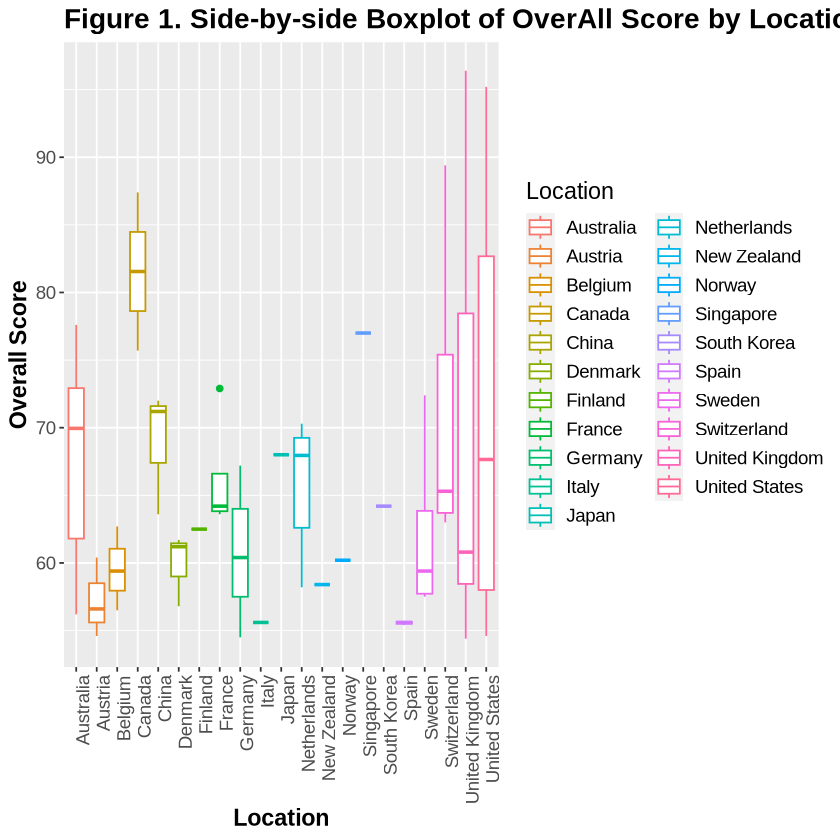

In [4]:
## Side-by-side Boxplot of OverAll Score by Location

worldRank_plot <- ggplot(worldRank, aes(x = Location, y = OverAll.Score, color = Location)) +
  geom_boxplot() +
  theme(
    text = element_text(size = 14),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    axis.text.x = element_text(angle = 90, hjust = 1)  
  ) +
  
  ggtitle("Figure 1. Side-by-side Boxplot of OverAll Score by Location") +
  xlab("Location") +
  ylab("Overall Score")

worldRank_plot 

### Figure 1. Interpretation

**Observations**
1) The University of Canada Singapore  has the highest median overall score
2) The University of Italy and University of Spain has the lowest median overall score
3) The University of UK and  US has the largest whiskers which represent the range of the data

Upon visual inspection, there is no obvious association between OverAll Score and Location. However, this will be investigated more closely in our Discussion Section.

For now, we shall remove this categorical variable from our prediction model, as it will not only complicate our predictive model, but a more in-depth investigation into this input variable will be performed (as explored in the Discussion Section).

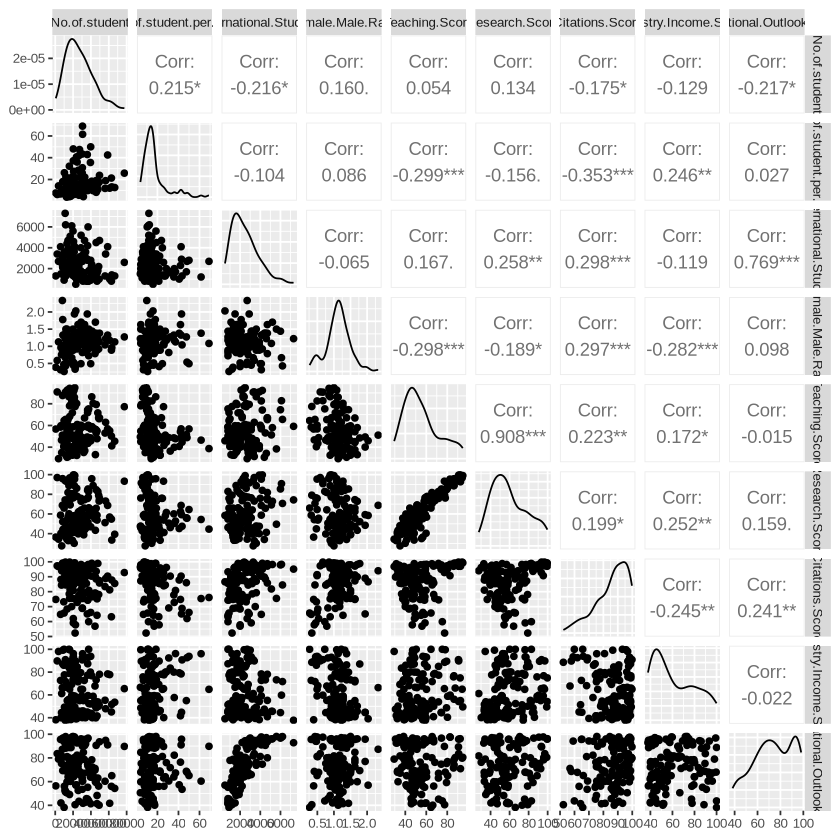

In [5]:
worldRank1 <- worldRank |> 
              select(-Location,-University.Rank,-Name.of.University)

worldRank_pairplot <- worldRank1 |>
                      select(-OverAll.Score) |>
                      ggpairs(progress = FALSE) +
                      theme(
                           text = element_text(size = 10),
                           plot.title = element_text(face = "bold"),
                           axis.title = element_text(face = "bold")
  )
worldRank_pairplot

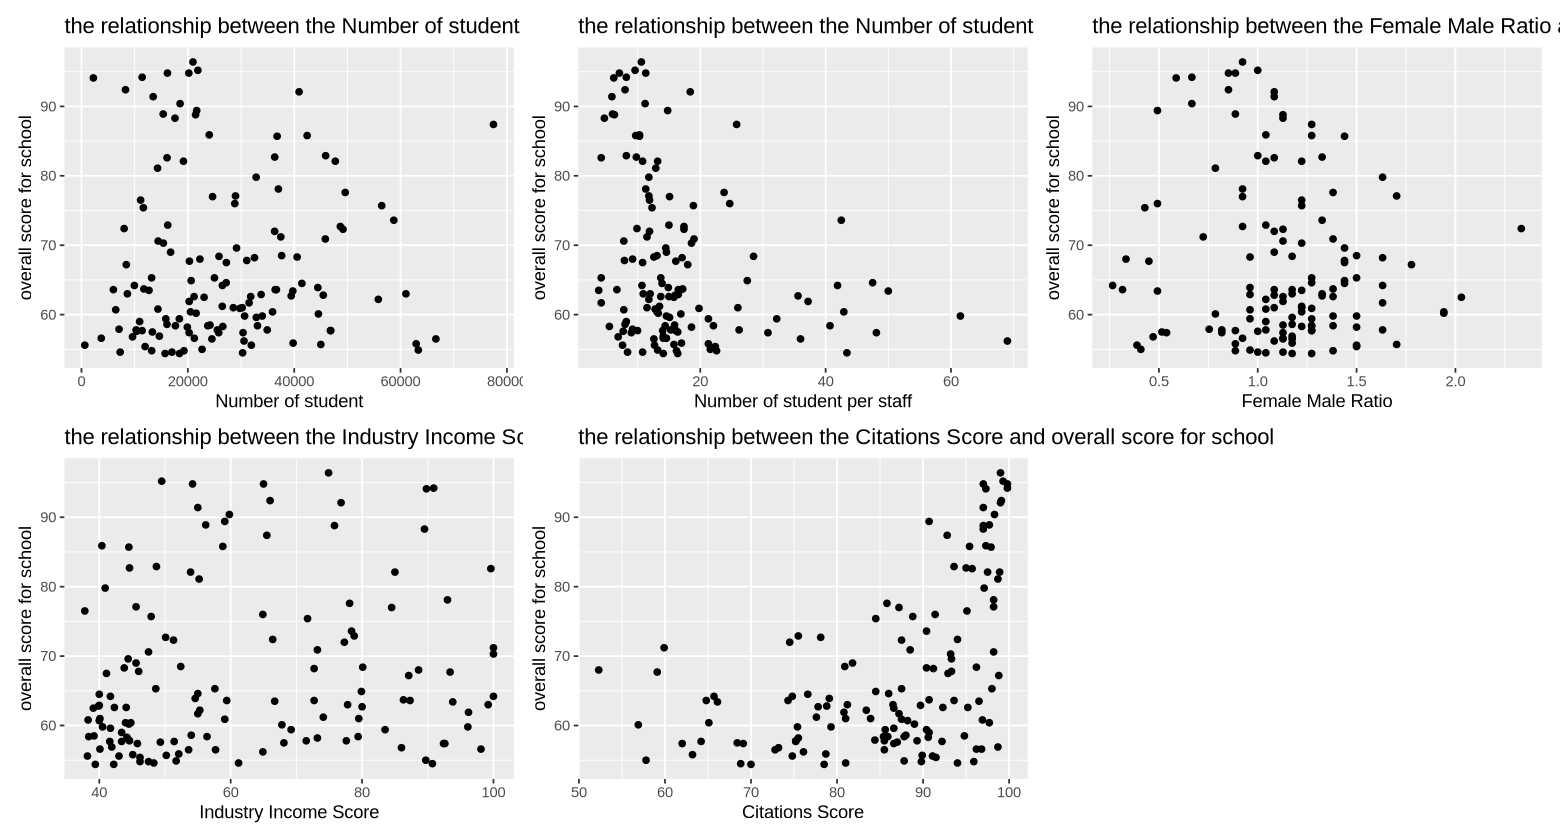

In [6]:
options(repr.plot.width = 13, repr.plot.height = 7)
plot1 <- ggplot(aes(x = No.of.student, y = OverAll.Score), data = worldRank1) +
        geom_point() +
        xlab("Number of student") +
        ylab("overall score for school") +
        ggtitle("the relationship between the Number of student and overall score for school")


plot2 <- ggplot(aes(x = No.of.student.per.staff, y = OverAll.Score), data = worldRank1) +
        geom_point() +
        xlab("Number of student per staff") +
        ylab("overall score for school") +
        ggtitle("the relationship between the Number of student per staff and overall score for school")


plot3 <- ggplot(aes(x = Female.Male.Ratio, y = OverAll.Score), data = worldRank1) +
        geom_point() +
        xlab("Female Male Ratio") +
        ylab("overall score for school") +
        ggtitle("the relationship between the Female Male Ratio and overall score for school")


plot4 <- ggplot(aes(x = Industry.Income.Score, y = OverAll.Score), data = worldRank1) +
        geom_point() +
        xlab("Industry Income Score") +
        ylab("overall score for school") +
        ggtitle("the relationship between the Industry Income Score and overall score for school")


plot5 <- ggplot(aes(x = Citations.Score, y = OverAll.Score), data = worldRank1) +
        geom_point() +
        xlab("Citations Score") +
        ylab("overall score for school") +
        ggtitle("the relationship between the Citations Score and overall score for school")


combined_plot <- plot1 + plot2 + plot3 + plot4 + plot5
combined_plot

### Figure 2. Interpretation

Owen

Eleanor

## Methods (b) Plan

Owen

Eleanor


### Feature Selection Process - Forward Selection

Owen 

Eleanor

In [14]:
# initial split
set.seed(1234)

# Split the data
worldRank_split <- initial_split(worldRank1, prop = 0.75, strata = OverAll.Score)
training_worldRank <- training(worldRank_split)
testing_worldRank <- testing(worldRank_split)

# Remove university names and University Rank
training_worldRank <- training_worldRank[, !colnames(training_worldRank) %in% c("Name.of.University")]
testing_worldRank <- testing_worldRank[, !colnames(testing_worldRank) %in% c("Name.of.University")]

worldRank_X_train <- as.matrix(training_worldRank[, -5])
worldRank_Y_train <- as.matrix(training_worldRank[, 5]) 
worldRank_X_test <- as.matrix(testing_worldRank[, -5])
worldRank_Y_test <- as.matrix(testing_worldRank[, 5])

In [15]:
worldRank_forward_sel <- regsubsets(
    x = OverAll.Score ~ . , nvmax = 9,
    data = training_worldRank,
    method = "forward" , )
worldRank_forward_summary <- summary(worldRank_forward_sel)
worldRank_forward_summary

Subset selection object
Call: regsubsets.formula(x = OverAll.Score ~ ., nvmax = 9, data = training_worldRank, 
    method = "forward", )
9 Variables  (and intercept)
                            Forced in Forced out
No.of.student                   FALSE      FALSE
No.of.student.per.staff         FALSE      FALSE
International.Student           FALSE      FALSE
Female.Male.Ratio               FALSE      FALSE
Teaching.Score                  FALSE      FALSE
Research.Score                  FALSE      FALSE
Citations.Score                 FALSE      FALSE
Industry.Income.Score           FALSE      FALSE
International.Outlook.Score     FALSE      FALSE
1 subsets of each size up to 9
Selection Algorithm: forward
         No.of.student No.of.student.per.staff International.Student
1  ( 1 ) " "           " "                     " "                  
2  ( 1 ) " "           " "                     " "                  
3  ( 1 ) " "           " "                     " "                  
4  ( 1 )

n_input_variables RSQ       RSS          ADJ.R2    Cp           BIC       
1 1                 0.8828896 1.652634e+03 0.8816946 1.741161e+06  -205.2535
2 2                 0.9725361 3.875640e+02 0.9719698 4.082533e+05  -345.6728
3 3                 0.9889217 1.563342e+02 0.9885755 1.646257e+05  -431.8561
4 4                 0.9986891 1.849864e+01 0.9986339 1.940064e+04  -640.6808
5 5                 0.9999932 9.640964e-02 0.9999928 1.357966e+01 -1161.7602
6 6                 0.9999938 8.819437e-02 0.9999933 6.923840e+00 -1166.0614
7 7                 0.9999939 8.632241e-02 0.9999934 6.951492e+00 -1163.6016
8 8                 0.9999939 8.552067e-02 0.9999934 8.106761e+00 -1159.9295
9 9                 0.9999939 8.541935e-02 0.9999933 1.000000e+01 -1155.4429

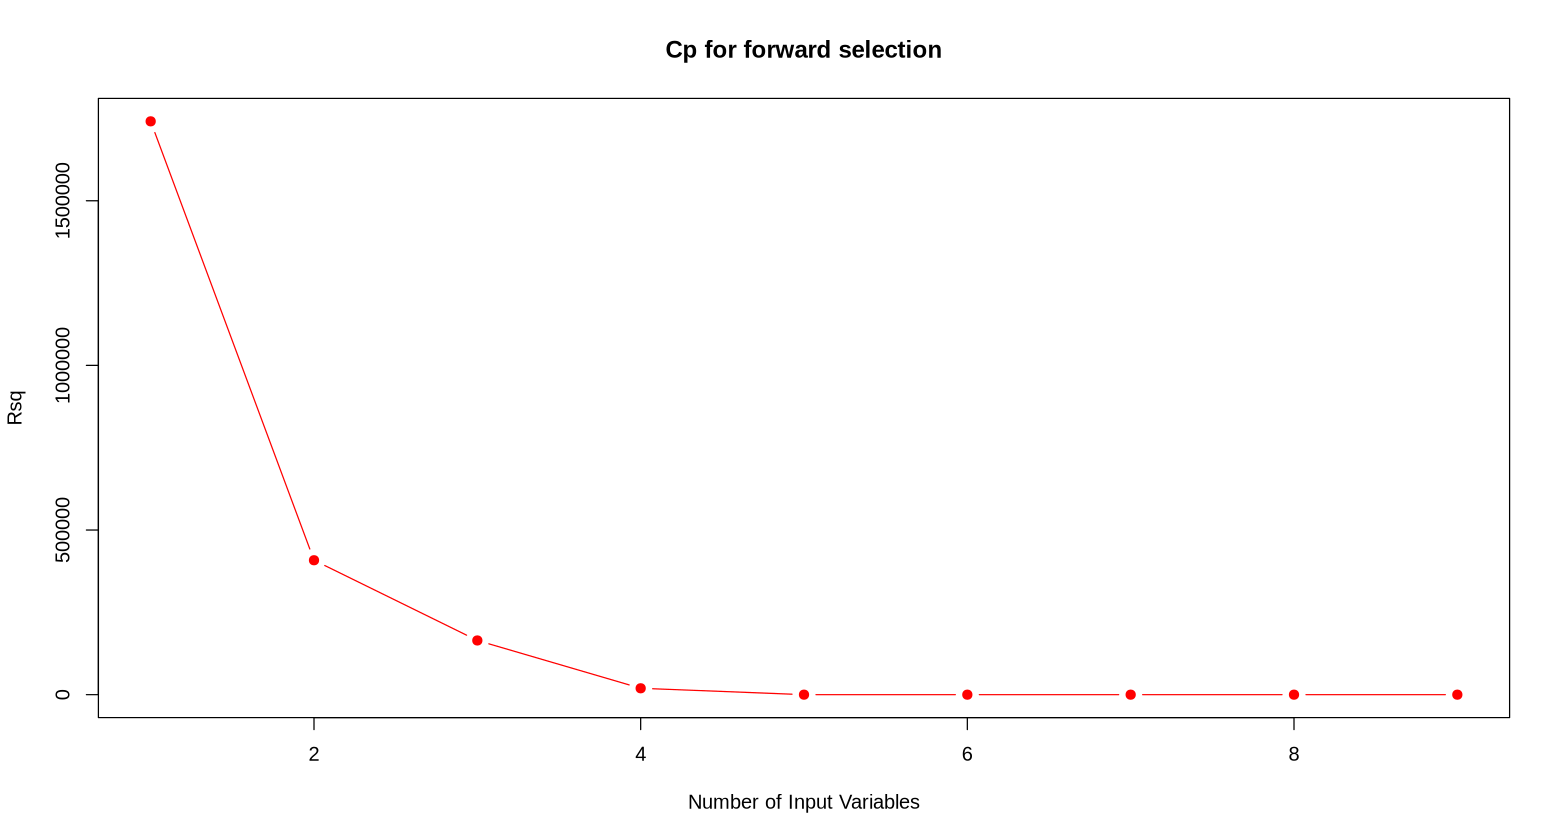

In [16]:
## check R-square 
worldRank_forward_summary_df <- tibble(
    n_input_variables = 1:9,
    RSQ = worldRank_forward_summary$rsq,
    RSS = worldRank_forward_summary$rss,
    ADJ.R2 = worldRank_forward_summary$adjr2,
    Cp = worldRank_forward_summary$cp,
    BIC = worldRank_forward_summary$bic,
)
worldRank_forward_summary_df

plot(summary(worldRank_forward_sel)$cp,
     main = "Cp for forward selection",
     xlab = "Number of Input Variables", ylab = "Rsq", type = "b", pch = 19,
     col = "red"
)

In [17]:
## selected variable 
cp_min = which.min(worldRank_forward_summary$cp)
selected_var <- names(coef(worldRank_forward_sel,cp_min))[-1]
as.matrix(selected_var)

[,1]                       
[1,] Female.Male.Ratio          
[2,] Teaching.Score             
[3,] Research.Score             
[4,] Citations.Score            
[5,] Industry.Income.Score      
[6,] International.Outlook.Score

In [18]:
## define the new training and test set 
training_subset <- training_worldRank %>% select(selected_var,OverAll.Score)
testing_subset <- testing_worldRank %>% select(selected_var,OverAll.Score)

## using the tidymodels
lm_spec <- linear_reg() %>% 
  set_engine("lm") %>% 
  set_mode("regression")

lm_recipe <- recipe(OverAll.Score ~ ., data = training_subset)

worldRank_full_tidy <- workflow() %>% 
  add_recipe(lm_recipe) %>% 
  add_model(lm_spec) %>% 
  fit(data = training_subset)

## Predict model and check the RMSE 
lm_test_resualts_selected <- worldRank_full_tidy |>
                    predict(testing_subset) |>
                    bind_cols(testing_subset) |>
                    metrics(truth = OverAll.Score, estimate = .pred)


lm_test_resualts_selected

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(selected_var)

  # Now:
  data %>% select(all_of(selected_var))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


.metric .estimator .estimate 
1 rmse    standard   0.03771847
2 rsq     standard   0.99998867
3 mae     standard   0.03270133

## Discussion

**Interprete the Evaluation Matrix Table** 
1) **Root Mean Squared Error(RMSE) is 0.03114514 suggests that, on average, the model's predictions are about 0.031 units away from the actual values. The smaller RMSE, the better fit.** 
2) **R-squared(RSQ) is 0.99999346 suggests that the model explains approximately 99.999% of the variance in the response variable , which indicate the perfect fit**
3) **MAE(Mean Absolute Error) shows the model's predictions are about 0.026 units away from the actual values.**

**Overall, We build the reasonable predictive model by using forward selection to select our variable subset,and we want to futher using the 2024 World Rank to check if our model can perfect predict the Univerity's overall score**   